<a href="https://colab.research.google.com/github/HNXJ/AdvNeuroscience/blob/master/Hw6p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')

# !pip install wget
# import wget
# wget.download('https://raw.githubusercontent.com/HNXJ/QMC/master/1.jpg')

# Assignment No.6 : Reinforcement Learning

> Advanced neuroscience - Dr.Ali Ghazizade

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcREFhPnPZNywQMid6Jn2_TvANPzpFzPZZaAouZkkDOWgp65WReg&usqp=CAU)

> Hamed Nejat - 96102578

________________

# Learning the Water Maze

As an example of generalized reinforcement learning, we consider the water maze task. This is a navigation problem in which rats are placed in a large pool of milky water and have to swim around until they find a small platform that is submerged slightly below the surface of the water. The opaqueness of the water prevents them from seeing the platform directly, and their natural aversion to water (although they are competent swimmers) motivates them to find the platform. After several trials, the rats learn the location of the platform and swim directly to it when placed in the water. We are going to simulate a simple model of navigation problem. 

#### 10x10 example:

![alt text](https://raw.githubusercontent.com/HNXJ/QMC/master/1.jpg)

### Simulation parameters:

* 15x15 map

* Fixed target

* Fixed cat

* Random starting point in eacg trial

* 4 directions for moving

* Probability to move in 4 directions

* Uniform probability at first

* Step by step movement

* End; being with cat or in target

For better implementation, we've implemented a class called "WaterMaze" with those parameters:

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import time


class SessionLog:
  def __init__(self):
    self.path = None
    self.maze = None
    self.error = 0
    return

  def get_path(self):
    return self.path

  def get_maze(self):
    return self.maze

  def get_error(self):
    return self.error

  def set_error(self, error):
    self.error = error

  def set_path(self, path):
    self.path = path

  def set_maze(self, maze):
    self.maze = maze

class WaterMaze:

  def __init__(self, mapsize=(17, 17), eps=0.1, noisyRun=False):
    self.maze = np.zeros(mapsize)
    self.maze += 0.5

    self.maze[:, 0] = -2
    self.maze[:, 16] = -2
    self.maze[0, :] = -2
    self.maze[16, :] = -2
    
    self.eps = eps
    self.maze[3, 4] = 1.5
    self.maze[9, 11] = -1.5
    self.currentpath = 0

    self.paths = None
    self.logs = []
    self.fig = None
    self.ax = None
    return

  @staticmethod
  def getDirection(p, epsl=0.0):
    ps = p
    for i in range(1, 4):
      ps[i] += ps[i-1]
    ps /= ps[3]
    q = np.random.rand()

    r = np.random.rand()
    if r < epsl:
      return np.random.randint(0, 4)

    if q < ps[0]:
      return 0
    elif q < ps[1]:
      return 1
    elif q < ps[2]:
      return 2
    elif q < ps[3]:
      return 3

  @staticmethod
  def getArgmax(p, epsl=0.0):
    q = np.where(p == np.max(p))
    if q[0].shape[0] < 1:
      return q[0][0]
    idx = np.random.randint(0, q[0].shape[0])
    idx = q[0][idx]
    r = np.random.rand()
    if r < epsl:
      return np.random.randint(0, 4)
    return idx

  def getErrLog(self):
    y = np.zeros(len(self.logs))
    for i in range(len(self.logs)):
      y[i] = self.logs[i].error
    return y

  def errPlotter(self, ax, title="Mean accuracy over sessions"):
    y = self.getErrLog()
    ax.plot(y)
    ax.set_ylim([0, 1])
    ax.set_title(title)
    ax.set_xlabel("Sessions")
    ax.grid(True)
    return

  def animate(self, ax, title="Session heatmap"):
    
      ax.imshow(self.maze)
      ax.text(4, 3+0.3, "T")
      ax.text(11, 9+0.3, "X")
      ax.set_title(title)

      for i in range(1, 16):
        for j in range(1, 16):
          ax.text(i-0.3, j-0.1, "%.4f" % (float(self.maze[j, i])))

      return

  def plotpath(self, ax, title, paths):
      # ax.imshow(self.maze)
      ax.text(4, 3+0.3, "T")
      ax.text(11, 9+0.3, "X")
      ax.set_title(title)

      for i in range(paths.shape[1]):
        ax.text(paths[1, i]-0.4, paths[0, i]+0.9, "*", fontsize=48)

      return

  def runTrial(self, x, y, mode="argmax", epsl=0.0, lambd=1.0):
    
    if x > 15:
      x -= 1
    if x < 1:
      x += 1
    if y > 15:
      y -= 1
    if y < 1:
      y += 1

    if self.maze[x, y] <= -1.49:
      self.flag = 1
      return -1, -1
    
    if self.maze[x, y] >= 1.49:
      self.flag = -1
      return -1, -1
    
    self.paths = np.concatenate([self.paths, np.array([[x], [y]])], 1)
    
    p = np.array([self.maze[x-1, y], self.maze[x+1, y] ,self.maze[x, y-1] ,self.maze[x, y+1]])
    
    if x <= 1:
      p[0] = 0
    elif x >= 15:
      p[1] = 0
    if y <= 1:
      p[2] = 0
    elif y >= 15:
      p[3] = 0

    # print(x, y, p)
    if mode=="argmax":
      idx = self.getArgmax(p, epsl=epsl)
    elif mode=="probabilistic":
      idx = self.getDirection(p, epsl=epsl)
    
    if idx == 0:
      return x-1, y
    elif idx == 1:
      return x+1, y
    elif idx == 2:
      return x, y-1
    else:
      return x, y+1
   
  def runSession(self, epochs=100, maxlen=100, animate=False, mode="argmax", epsl=0.0, lambd=0.5, flag=0):

    cnt = 0.0
    for i in range(epochs):
      xt = np.random.randint(1, 16)
      yt = np.random.randint(1, 16)

      self.flag = flag
      self.paths = np.array([[0], [0]])

      while self.paths.shape[1] < maxlen and (not xt == -1):
        xt, yt = self.runTrial(xt, yt, mode, epsl=epsl)

      if self.flag:
        for i in range(self.paths.shape[1]):
          self.maze[self.paths[0, i], self.paths[1, i]] -= self.eps*self.flag*(i/self.paths.shape[1])*np.exp(i*np.log(lambd))

      self.maze[3, 4] = 0.0
      self.maze[9, 11] = 0.0
      self.maze[1:16, 1:16] /= np.max(np.abs(self.maze[1:16, 1:16]))
      self.maze[1:16, 1:16] -= np.min(self.maze[1:16, 1:16])
      self.maze[3, 4] = 1.5
      self.maze[9, 11] = -1.5   

      slog = SessionLog()

      if self.flag < 0:
        cnt = cnt*0.95 + 0.05 + 0.2*(1 - cnt)**2
      else:
        cnt = cnt*0.95

      slog.set_error(cnt)
      slog.set_path(self.paths)
      slog.set_maze(self.maze*1.0)
      self.logs.append(slog)

      if animate:
        time.sleep(0.500)
        self.animate()

  def runSessionTD(self, epochs=100, maxlen=100, animate=False, mode="argmax", epsl=0.0, gamma=1.0, lambds=1.0, flag=0):

    cnt = 0.0
    for i in range(epochs):
      xt = np.random.randint(1, 16)
      yt = np.random.randint(1, 16)

      self.flag = flag
      self.paths = np.array([[0], [0]])

      while self.paths.shape[1] < maxlen and (not xt == -1):
        xt, yt = self.runTrial(xt, yt, mode, epsl=epsl, lambd=lambds)
    
      if self.flag:
        for i in range(self.paths.shape[1]):
          if i:
            tdl = self.maze[self.paths[0, i-1], self.paths[1, i-1]]*lambds
          else:
            tdl = 0
          self.maze[self.paths[0, i], self.paths[1, i]] -= (self.eps*self.flag*(i/self.paths.shape[1])*np.exp(i*np.log(gamma) - tdl))

      self.maze[3, 4] = 0.0
      self.maze[9, 11] = 0.0
      self.maze[1:16, 1:16] /= np.max(np.abs(self.maze[1:16, 1:16]))
      self.maze[1:16, 1:16] -= np.min(self.maze[1:16, 1:16])
      self.maze[3, 4] = 1.5
      self.maze[9, 11] = -1.5   

      slog = SessionLog()
      if self.flag < 0:
        cnt = cnt*0.95 + 0.05 + 0.2*(1 - cnt)**2
      else:
        cnt = cnt*0.95
      
      slog.set_error(cnt)
      slog.set_path(self.paths)
      slog.set_maze(self.maze*1.0)
      self.logs.append(slog)

      if animate:
        time.sleep(0.500)
        self.animate()


class WaterMazeT:

  def __init__(self, mapsize=(17, 17), eps=0.1, noisyRun=False):
    self.maze = np.zeros(mapsize)
    self.maze += 0.5

    self.maze[:, 0] = -2
    self.maze[:, 16] = -2
    self.maze[0, :] = -2
    self.maze[16, :] = -2
    
    self.eps = eps
    self.maze[3, 4] = 1.5
    self.maze[5, 12] = 2.5
    self.maze[9, 11] = -1.5
    self.currentpath = 0

    self.paths = None
    self.logs = []
    self.fig = None
    self.ax = None
    return

  @staticmethod
  def getDirection(p, epsl=0.0):
    ps = p
    for i in range(1, 4):
      ps[i] += ps[i-1]
    ps /= ps[3]
    q = np.random.rand()

    r = np.random.rand()
    if r < epsl:
      return np.random.randint(0, 4)

    if q < ps[0]:
      return 0
    elif q < ps[1]:
      return 1
    elif q < ps[2]:
      return 2
    elif q < ps[3]:
      return 3

  @staticmethod
  def getArgmax(p, epsl=0.0):
    q = np.where(p == np.max(p))
    if q[0].shape[0] < 1:
      return 1
    idx = np.random.randint(0, q[0].shape[0])
    idx = q[0][idx]
    r = np.random.rand()
    if r < epsl:
      return np.random.randint(0, 4)
    return idx

  def getErrLog(self):
    y = np.zeros(len(self.logs))
    for i in range(len(self.logs)):
      y[i] = self.logs[i].error
    return y

  def errPlotter(self, ax, title="Mean accuracy over sessions"):
    y = self.getErrLog()
    ax.plot(y)
    ax.set_ylim([0, 1])
    ax.set_title(title)
    ax.set_xlabel("Sessions")
    ax.grid(True)
    return

  def animate(self, ax, title="Session heatmap"):
    
      ax.imshow(self.maze)
      ax.text(4, 3+0.3, "T")
      ax.text(5, 12+0.3, "T")
      ax.text(11, 9+0.3, "X")
      ax.set_title(title)

      for i in range(1, 16):
        for j in range(1, 16):
          ax.text(i-0.3, j-0.1, "%.4f" % (float(self.maze[j, i])))

      return

  def plotpath(self, ax, title, paths):
      # ax.imshow(self.maze)
      ax.text(4, 3+0.3, "T")
      ax.text(5, 12+0.3, "T")
      ax.text(11, 9+0.3, "X")
      ax.set_title(title)

      for i in range(paths.shape[1]):
        ax.text(paths[1, i]-0.4, paths[0, i]+0.9, "*", fontsize=48)

      return

  def runTrial(self, x, y, mode="argmax", epsl=0.0, lambd=1.0):
    
    if x > 15:
      x -= 1
    if x < 1:
      x += 1
    if y > 15:
      y -= 1
    if y < 1:
      y += 1

    if self.maze[x, y] <= -1.49:
      self.flag = 1
      return -1, -1
    
    if self.maze[x, y] >= 1.49:
      self.flag = -1
      return -1, -1
    
    self.paths = np.concatenate([self.paths, np.array([[x], [y]])], 1)
    
    p = np.array([self.maze[x-1, y], self.maze[x+1, y] ,self.maze[x, y-1] ,self.maze[x, y+1]])
    
    if x <= 1:
      p[0] = 0
    elif x >= 15:
      p[1] = 0
    if y <= 1:
      p[2] = 0
    elif y >= 15:
      p[3] = 0

    # print(x, y, p)
    if mode=="argmax":
      idx = self.getArgmax(p, epsl=epsl)
    elif mode=="probabilistic":
      idx = self.getDirection(p, epsl=epsl)
    
    if idx == 0:
      return x-1, y
    elif idx == 1:
      return x+1, y
    elif idx == 2:
      return x, y-1
    else:
      return x, y+1
   
  def runSession(self, epochs=100, maxlen=100, animate=False, mode="argmax", epsl=0.0, lambd=0.5, flag=0):

    cnt = 0.0
    for i in range(epochs):
      xt = np.random.randint(1, 16)
      yt = np.random.randint(1, 16)

      self.flag = flag
      self.paths = np.array([[0], [0]])

      while self.paths.shape[1] < maxlen and (not xt == -1):
        xt, yt = self.runTrial(xt, yt, mode, epsl=epsl)

      if self.flag:
        for i in range(self.paths.shape[1]):
          self.maze[self.paths[0, i], self.paths[1, i]] -= self.eps*self.flag*(i/self.paths.shape[1])*np.exp(i*np.log(lambd))

      self.maze[3, 4] = 0.0
      self.maze[5, 12] = 0.0
      self.maze[9, 11] = 0.0

      self.maze[1:16, 1:16] /= np.max(np.abs(self.maze[1:16, 1:16]))
      self.maze[1:16, 1:16] -= np.min(self.maze[1:16, 1:16])
      
      self.maze[3, 4] = 1.5
      self.maze[5, 12] = 2.5
      self.maze[9, 11] = -1.5   

      slog = SessionLog()

      if self.flag < 0:
        cnt = cnt*0.95 + 0.05 + 0.2*(1 - cnt)**2
      else:
        cnt = cnt*0.95

      slog.set_error(cnt)
      slog.set_path(self.paths)
      slog.set_maze(self.maze*1.0)
      self.logs.append(slog)

      if animate:
        time.sleep(0.500)
        self.animate()

  def runSessionTD(self, epochs=100, maxlen=100, animate=False, mode="argmax", epsl=0.0, gamma=1.0, lambds=1.0, flag=0):

    cnt = 0.0
    for i in range(epochs):
      xt = np.random.randint(1, 16)
      yt = np.random.randint(1, 16)

      self.flag = flag
      self.paths = np.array([[0], [0]])

      while self.paths.shape[1] < maxlen and (not xt == -1):
        xt, yt = self.runTrial(xt, yt, mode, epsl=epsl, lambd=lambds)
    
      if self.flag:
        for i in range(self.paths.shape[1]):
          if i:
            tdl = self.maze[self.paths[0, i-1], self.paths[1, i-1]]*lambds
          else:
            tdl = 0
          self.maze[self.paths[0, i], self.paths[1, i]] -= (self.eps*self.flag*(i/self.paths.shape[1])*np.exp(i*np.log(gamma) - tdl))

      self.maze[3, 4] = 0.0
      self.maze[5, 12] = 0.0
      self.maze[9, 11] = 0.0

      self.maze[1:16, 1:16] /= np.max(np.abs(self.maze[1:16, 1:16]))
      self.maze[1:16, 1:16] -= np.min(self.maze[1:16, 1:16])
      
      self.maze[3, 4] = 1.5
      self.maze[5, 12] = 2.5
      self.maze[9, 11] = -1.5   

      slog = SessionLog()
      if self.flag < 0:
        cnt = cnt*0.95 + 0.05 + 0.2*(1 - cnt)**2
      else:
        cnt = cnt*0.95
      
      slog.set_error(cnt)
      slog.set_path(self.paths)
      slog.set_maze(self.maze*1.0)
      self.logs.append(slog)

      if animate:
        time.sleep(0.500)
        self.animate()


# Q1&Q2: Paths before and after training with gradient contour

In this part, we've integrated both paths and contours during training for each scenario and parameters.

## I. Strictly argmax policy for MDM (exploration=0)

In this state, every path increases its likelihood by epsilon, if it reachs target and else, its likelihood will be decreased; we can see that cat target is rarely reached because after some trials, mouse finds the target and as there is no stochasticity, it does'nt go to lower likelihoods and some "benefit paths" are formed, that they are shortcut to the target with less complexity.

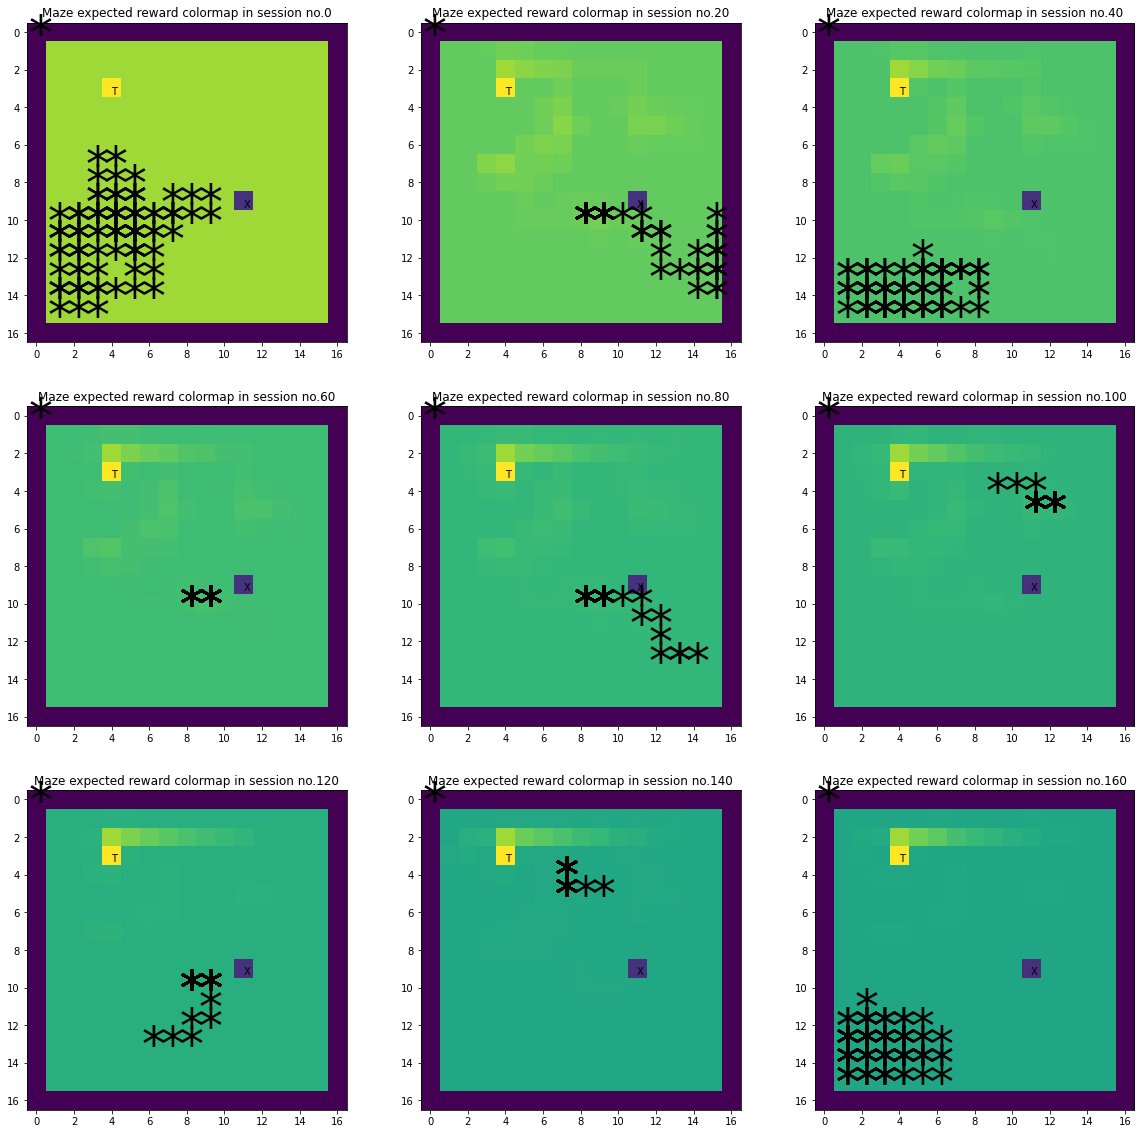

In [0]:
w1 = WaterMaze(eps=0.1)
w1.runSession(epochs=200, maxlen=100, animate=False, mode="argmax", epsl=0.0, lambd=1.0)
figs, plts = plt.subplots(figsize=(15, 15))

w1.animate(ax=plts)
w1.plotpath(ax=plts, title="Last session (1000) with an example of path", paths=w1.paths)
k = 20

fig, ax = plt.subplots(figsize=(20, 20), nrows=3, ncols=3)
for i in range(9):
  ax[int(i/3), i%3].imshow(w1.logs[i*k].maze)
  ax[int(i/3), i%3].set_title("Maze expected reward colormap in session no." + str(i*k))
  w1.plotpath(ax=ax[int(i/3), i%3], title="Maze expected reward colormap in session no." + str(i*k), paths=w1.logs[i*k].path)

## II. Stochastic argmax policy (exploration = 0.03)

Here, we will apply same policy but with exploration probability 0.03; 

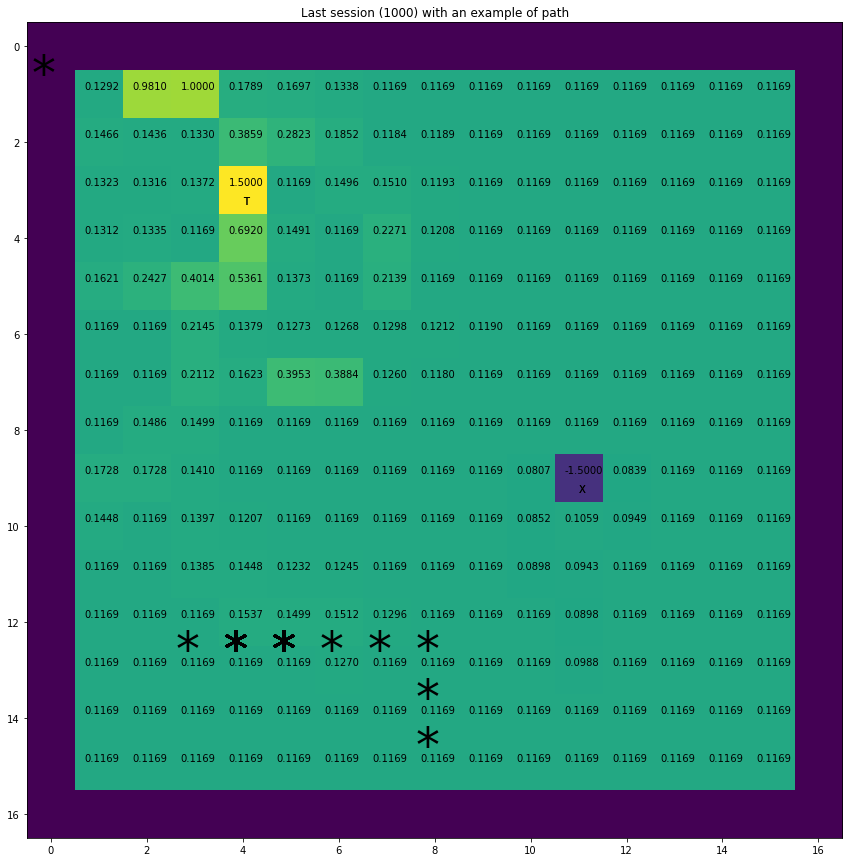

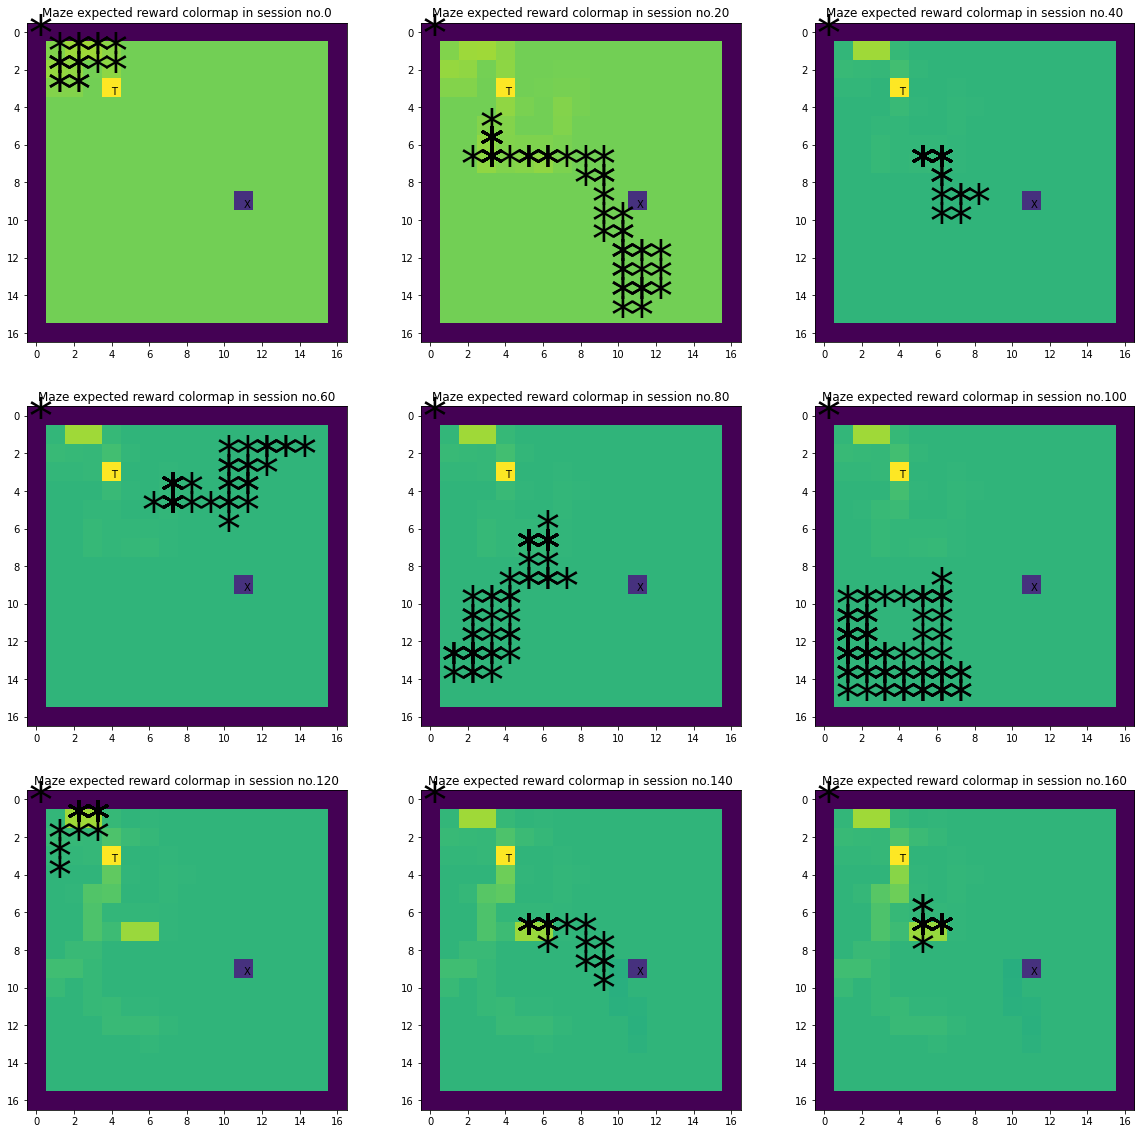

In [0]:
w2 = WaterMaze(eps=0.1)
w2.runSession(epochs=200, maxlen=100, animate=False, mode="argmax", epsl=0.03, lambd=1.0)
figs, plts = plt.subplots(figsize=(15, 15))

w2.animate(ax=plts)
w2.plotpath(ax=plts, title="Last session (1000) with an example of path", paths=w2.paths)
k = 20

fig, ax = plt.subplots(figsize=(20, 20), nrows=3, ncols=3)
for i in range(9):
  ax[int(i/3), i%3].imshow(w2.logs[i*k].maze)
  ax[int(i/3), i%3].set_title("Maze expected reward colormap in session no." + str(i*k))
  w2.plotpath(ax=ax[int(i/3), i%3], title="Maze expected reward colormap in session no." + str(i*k), paths=w2.logs[i*k].path)

## III. Probabilistic policy: (exploration=0)

In this state, every path increases its likelihood by epsilon, if it reachs target and else, its likelihood will be decreased; we can see that cat target is rarely reached because after some trials;

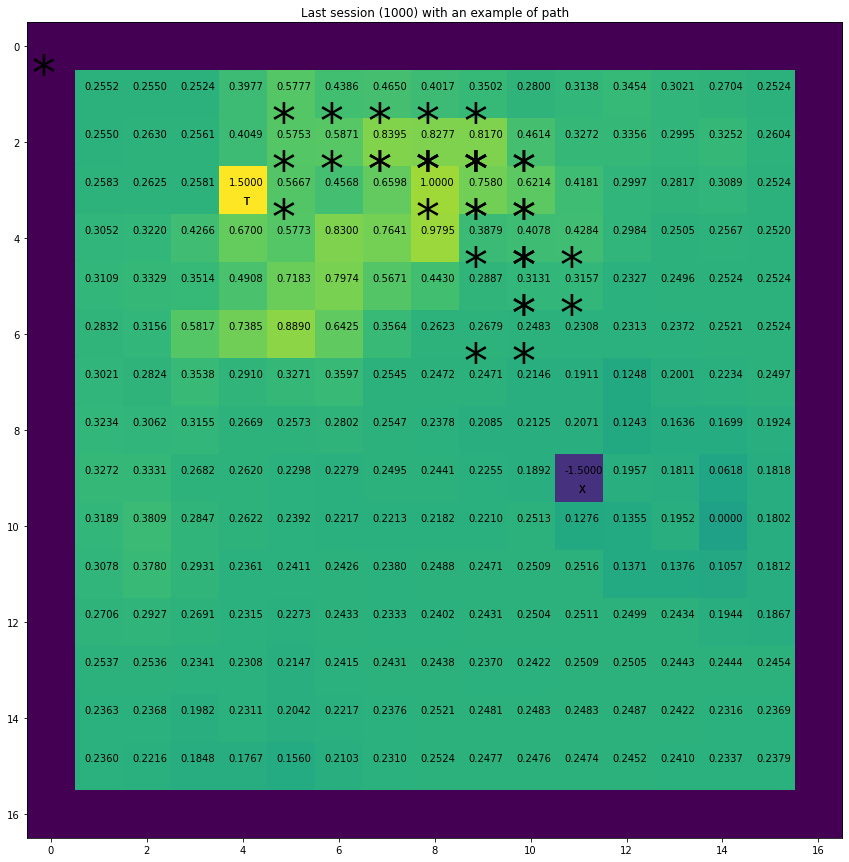

In [0]:
w3 = WaterMaze(eps=0.2)
w3.runSession(epochs=400, maxlen=100, animate=False, mode="probabilistic", epsl=0.0, lambd=1.0)
figs, plts = plt.subplots(figsize=(15, 15))

w3.animate(ax=plts)
w3.plotpath(ax=plts, title="Last session (1000) with an example of path", paths=w3.paths)
k = 40

fig, ax = plt.subplots(figsize=(20, 20), nrows=3, ncols=3)
for i in range(9):
  ax[int(i/3), i%3].imshow(w3.logs[i*k].maze)
  ax[int(i/3), i%3].set_title("Maze expected reward colormap in session no." + str(i*k))
  w3.plotpath(ax=ax[int(i/3), i%3], title="Maze expected reward colormap in session no." + str(i*k), paths=w3.logs[i*k].path)

## IV. Probabilistic policy: (exploration=0.03)

In [0]:
w4 = WaterMaze(eps=0.2)
w4.runSession(epochs=400, maxlen=100, animate=False, mode="probabilistic", epsl=0.03, lambd=1.0)
figs, plts = plt.subplots(figsize=(15, 15))

w4.animate(ax=plts)
w4.plotpath(ax=plts, title="Last session (400) with an example of path", paths=w4.paths)
k = 40

fig, ax = plt.subplots(figsize=(20, 20), nrows=3, ncols=3)
for i in range(9):
  ax[int(i/3), i%3].imshow(w4.logs[i*k].maze)
  ax[int(i/3), i%3].set_title("Maze expected reward colormap in session no." + str(i*k))
  w4.plotpath(ax=ax[int(i/3), i%3], title="Maze expected reward colormap in session no." + str(i*k), paths=w4.logs[i*k].path)

## V. TD-lambda approach

In this method, we change the update step by adding temporal difference error policy (TD) to the update equation:
$$  V_{t+1}(s_{t-k}) := V_{t}(s_{t-k}) + \lambda^{t}(V_{t+1}(S_{t}) - V_{t}(S_{t})) $$

The second term of this equation is called temporal difference (TD) value, special case of assuming $\lambda = 0$ is somehow equivalent to R-W method.

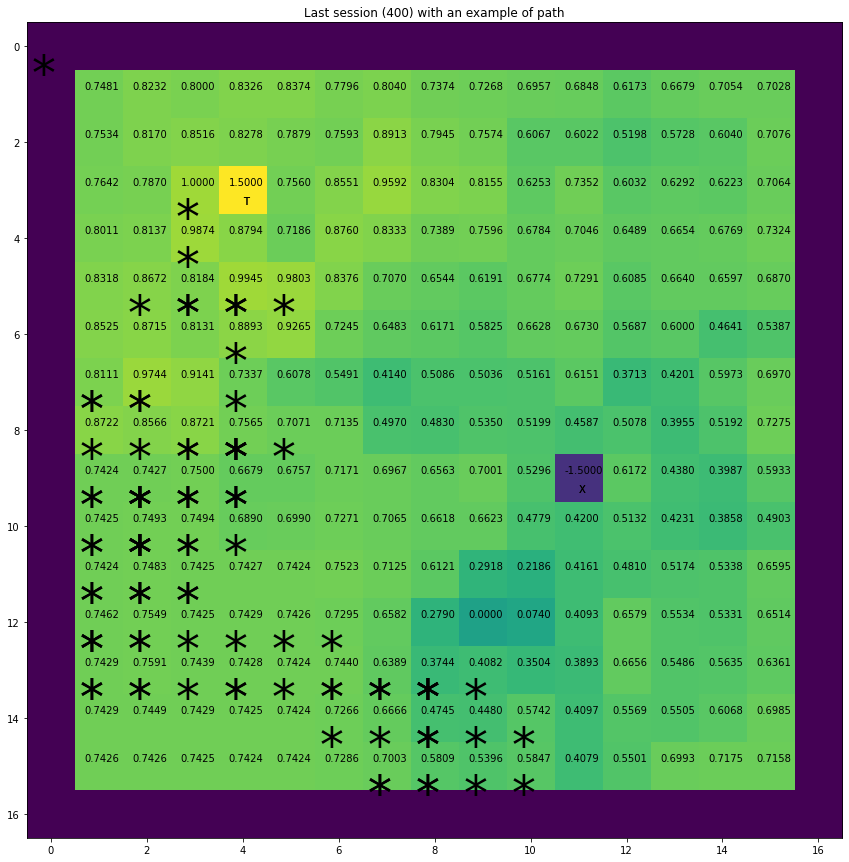

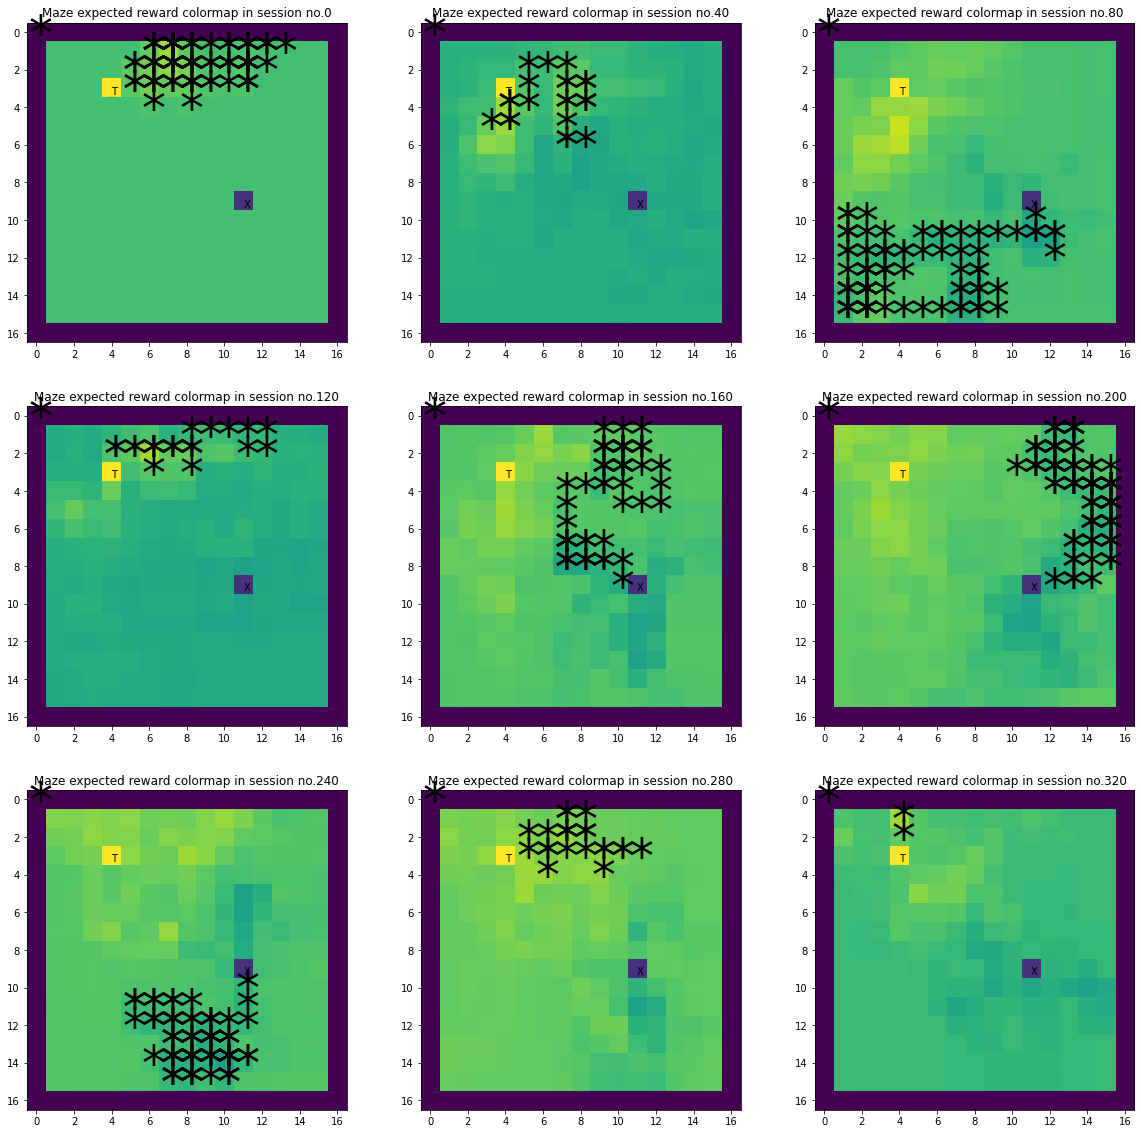

In [0]:
from matplotlib import pyplot as plt
from WaterMaze import WaterMaze

w5 = WaterMaze(eps=0.2)
w5.runSessionTD(epochs=400, maxlen=100, animate=False, mode="probabilistic", epsl=0.03, lambds=1.0)
figs, plts = plt.subplots(figsize=(15, 15))

w5.animate(ax=plts)
w5.plotpath(ax=plts, title="Last session (400) with an example of path", paths=w5.paths)
k = 40

fig, ax = plt.subplots(figsize=(20, 20), nrows=3, ncols=3)
for i in range(9):
  ax[int(i/3), i%3].imshow(w5.logs[i*k].maze)
  ax[int(i/3), i%3].set_title("Maze expected reward colormap in session no." + str(i*k))
  w5.plotpath(ax=ax[int(i/3), i%3], title="Maze expected reward colormap in session no." + str(i*k), paths=w5.logs[i*k].path)

# Q3: Effects of $\epsilon, \lambda \: and \: \gamma$ (learning rate, discount factor and temporal difference coefficient) 

In this part, we change these values for our models with different policies.



# Learning rate effect ($\epsilon$)

## I. Markov decision model (MDM deterministic) 

We expect that increasing the $\epsilon$ at first increases the convergence speed, but after some values this may lead to large and uncontrolled changes in model predictions. 

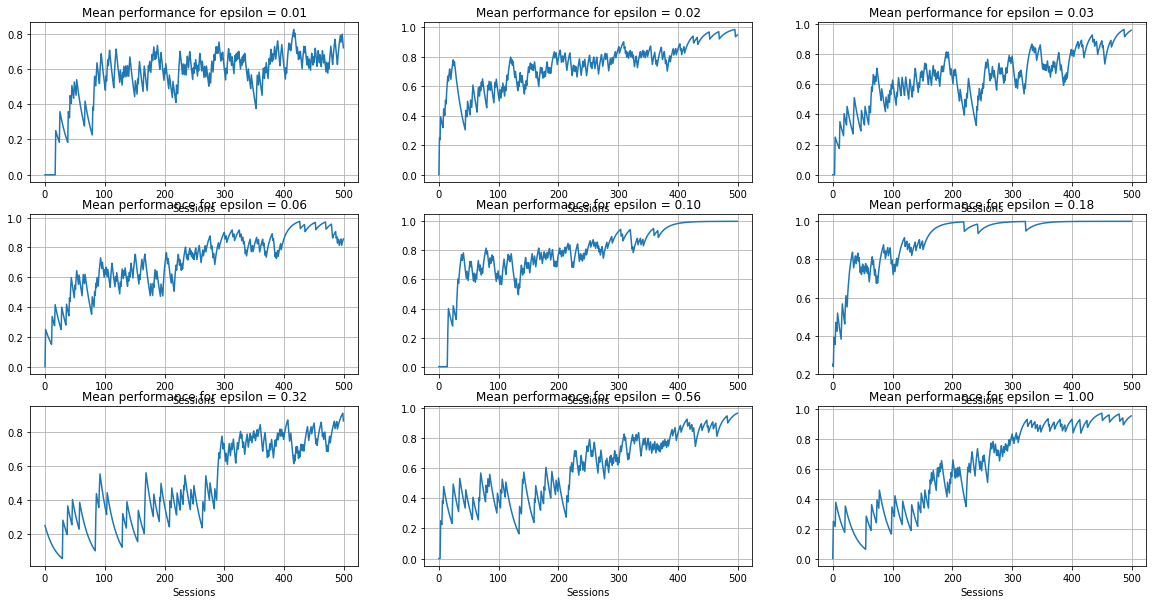

In [0]:
from matplotlib import pyplot as plt
from WaterMaze import WaterMaze
import numpy as np


epsil = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMaze(eps=epsil[i*3 + j])
    w.runSession(epochs=500, maxlen=50, animate=False, mode="argmax", epsl=0.0, lambd=1.0)
    w.errPlotter(ax=ax[i, j], title="Mean performance for epsilon = {:.2f}".format(epsil[i*3 + j]))

## II. MDM (stochastic)

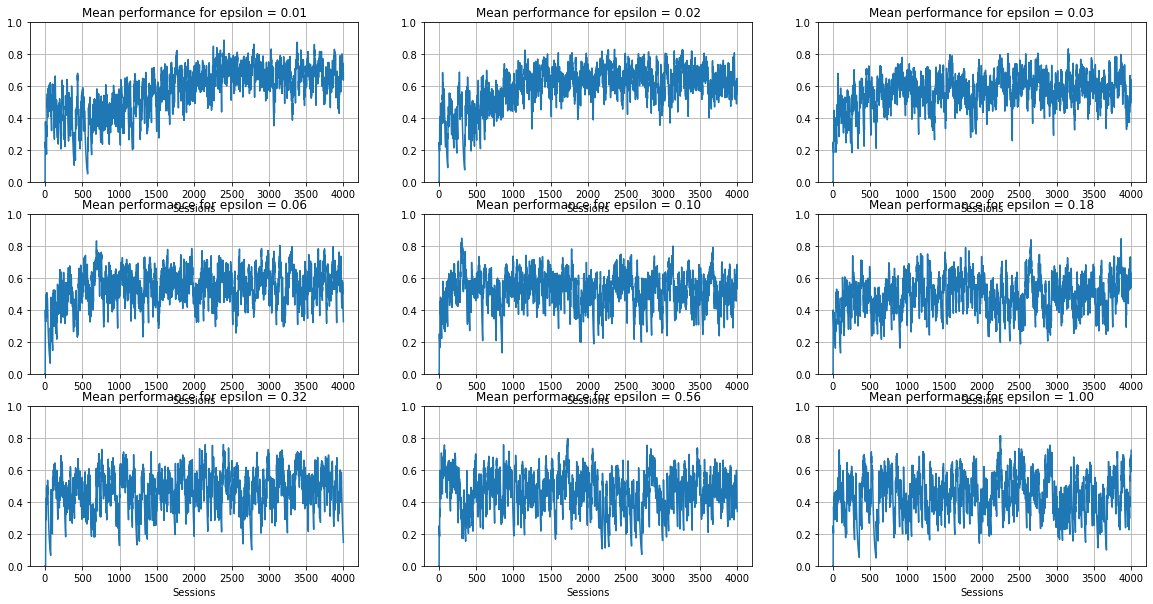

In [18]:
epsil = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMaze(eps=epsil[i*3 + j])
    w.runSession(epochs=4000, maxlen=50, animate=False, mode="probabilistic", epsl=0.0, lambd=1.0)
    w.errPlotter(ax=ax[i, j], title="Mean performance for epsilon = {:.2f}".format(epsil[i*3 + j]))

## III. MDM (Stochastic with exploration)

Epsilon effect for this scenario is almost same with first scenario

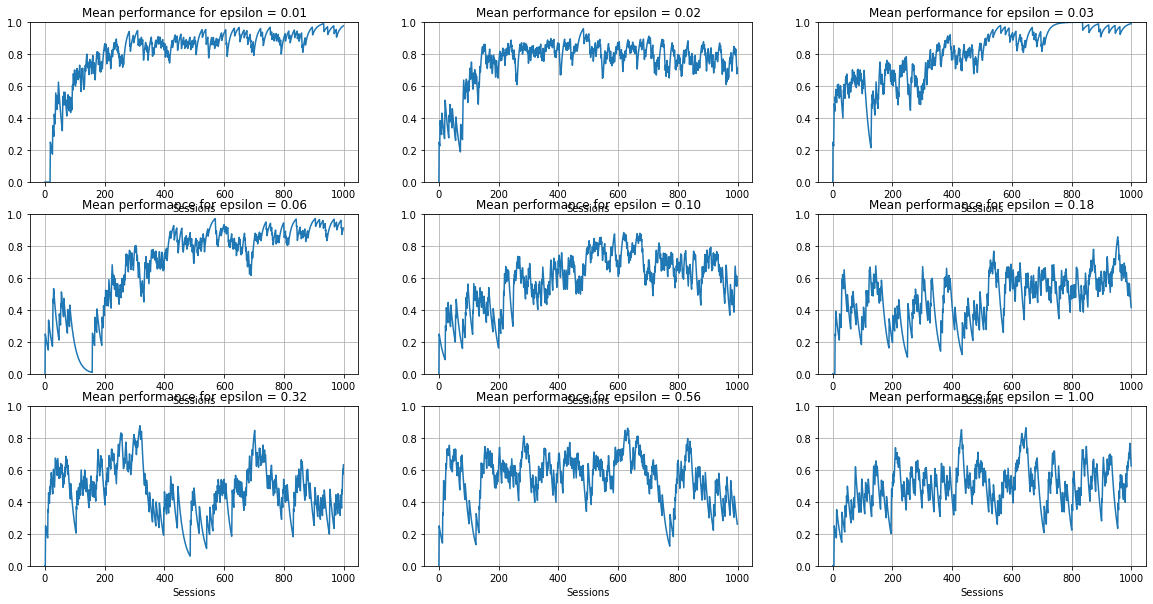

In [15]:
epsil = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMaze(eps=epsil[i*3 + j])
    w.runSession(epochs=1000, maxlen=30, animate=False, mode="argmax", epsl=0.1, lambd=1.0)
    w.errPlotter(ax=ax[i, j], title="Mean performance for epsilon = {:.2f}".format(epsil[i*3 + j]))

## IV. TD($\lambda$) (deterministic)

For lower epsilons, we can see linear increasing accuracy; that means the epsilon is low $(\epsilon < 0.03)$ and for values about 0.1, the convergence is almost optimal (in average). 

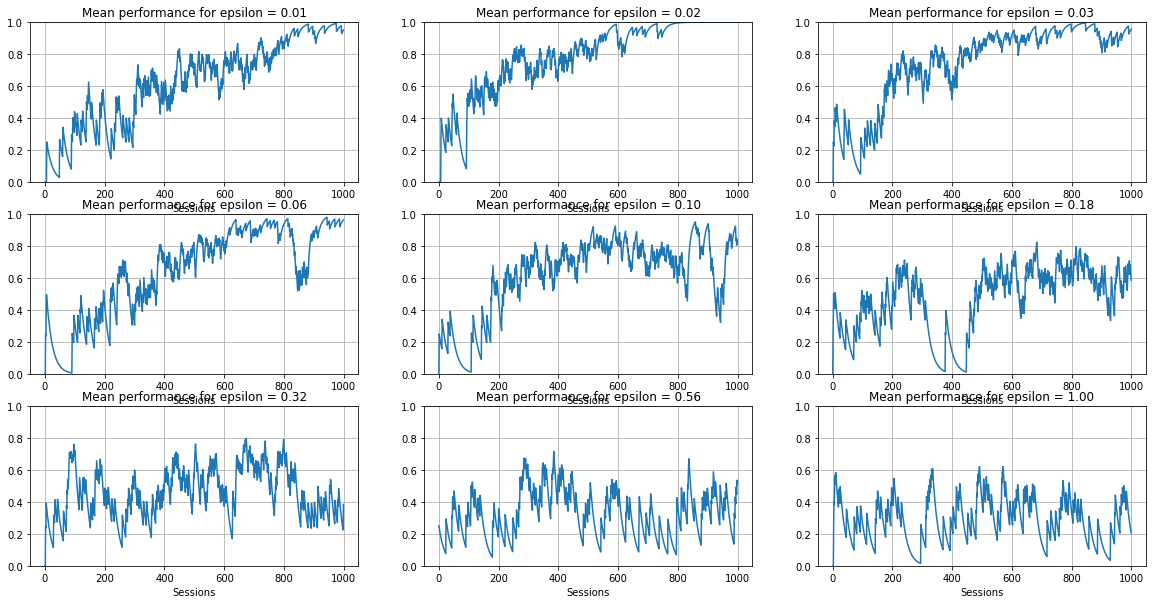

In [13]:
epsil = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMaze(eps=epsil[i*3 + j])
    w.runSessionTD(epochs=1000, maxlen=100, animate=False, mode="argmax", epsl=0.0, lambds=0.8)
    w.errPlotter(ax=ax[i, j], title="Mean performance for epsilon = {:.2f}".format(epsil[i*3 + j]))

## V. TD($\lambda$) (exploration)

In [14]:
epsil = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMaze(eps=epsil[i*3 + j])
    w.runSessionTD(epochs=1000, maxlen=30, animate=False, mode="argmax", epsl=0.1, lambds=0.8)
    w.errPlotter(ax=ax[i, j], title="Mean performance for epsilon = {:.2f}".format(epsil[i*3 + j]))

IndexError: ignored

# Discount factor effect ($\gamma$)

Lower discount factor causes less changes in far parts of path, so the propagation will be less and we expect lower speed in training; here we can see that this is happening, higher diccount factors (near 1) have better effect on training procedure and less oscillation of accuracy.

## I. MDM deterministic

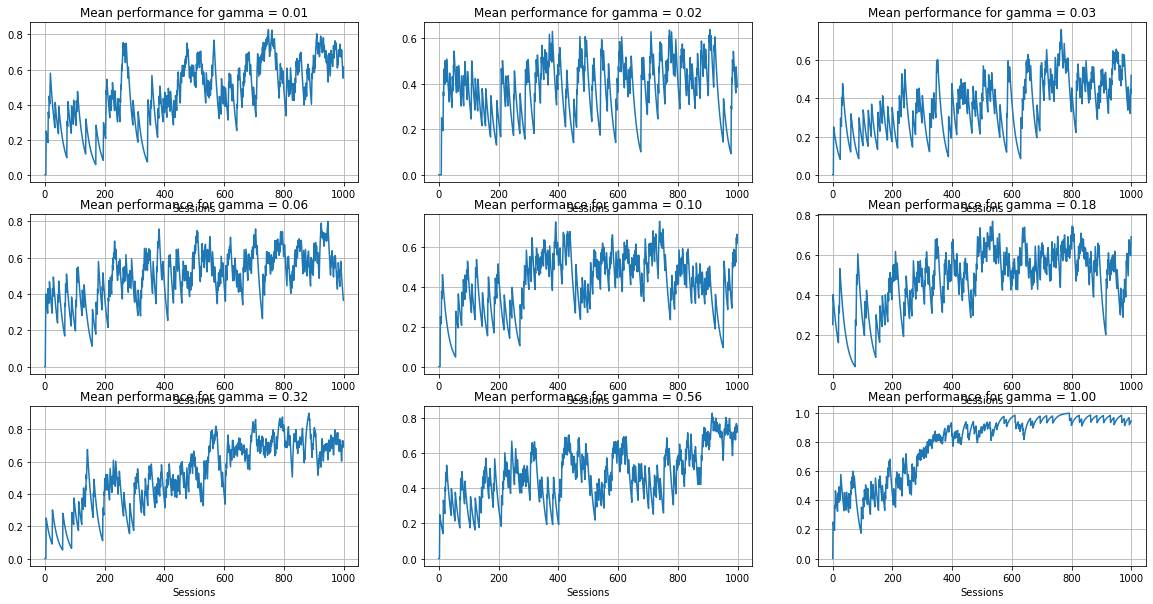

In [0]:
gammas = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMaze(eps=0.1)
    w.runSession(epochs=1000, maxlen=30, animate=False, mode="argmax", epsl=0.0, lambd=gammas[i*3 + j])
    w.errPlotter(ax=ax[i, j], title="Mean performance for gamma = {:.2f}".format(gammas[i*3 + j]))

## II. MDM (stochastic)

Stochastic scenario in MDM is not good, map is not explored totally and this stochasticness causes wrong updates in the reward map.

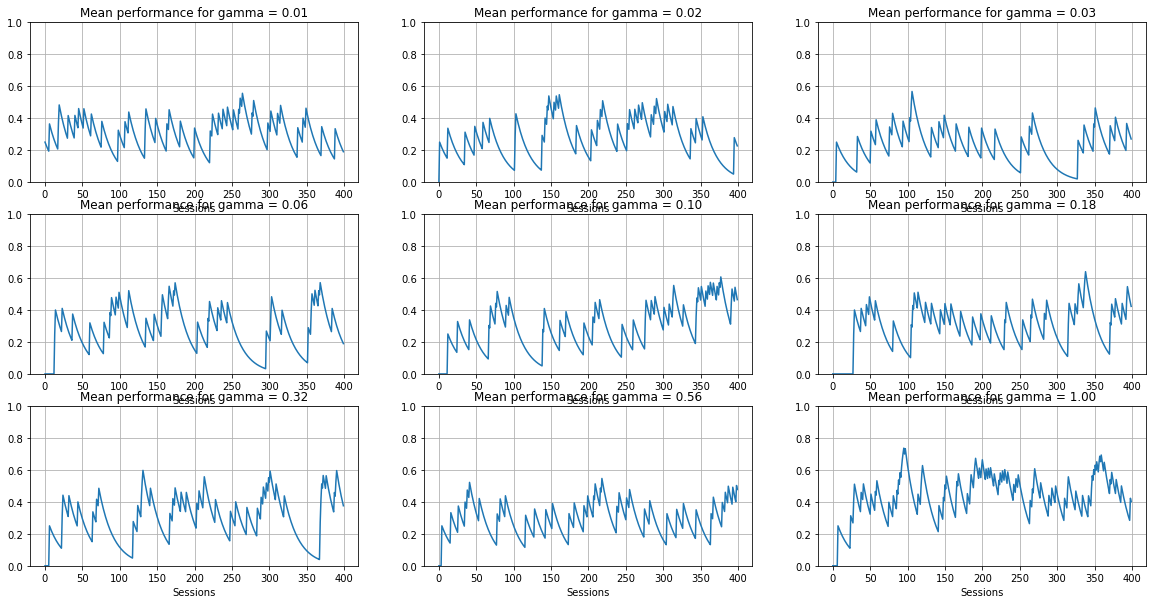

In [12]:
gammas = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMaze(eps=0.1)
    w.runSession(epochs=400, maxlen=30, animate=False, mode="probabilistic", epsl=0.0, lambd=gammas[i*3 + j])
    w.errPlotter(ax=ax[i, j], title="Mean performance for gamma = {:.2f}".format(gammas[i*3 + j]))

## III. MDM (Stochastic with exploration)

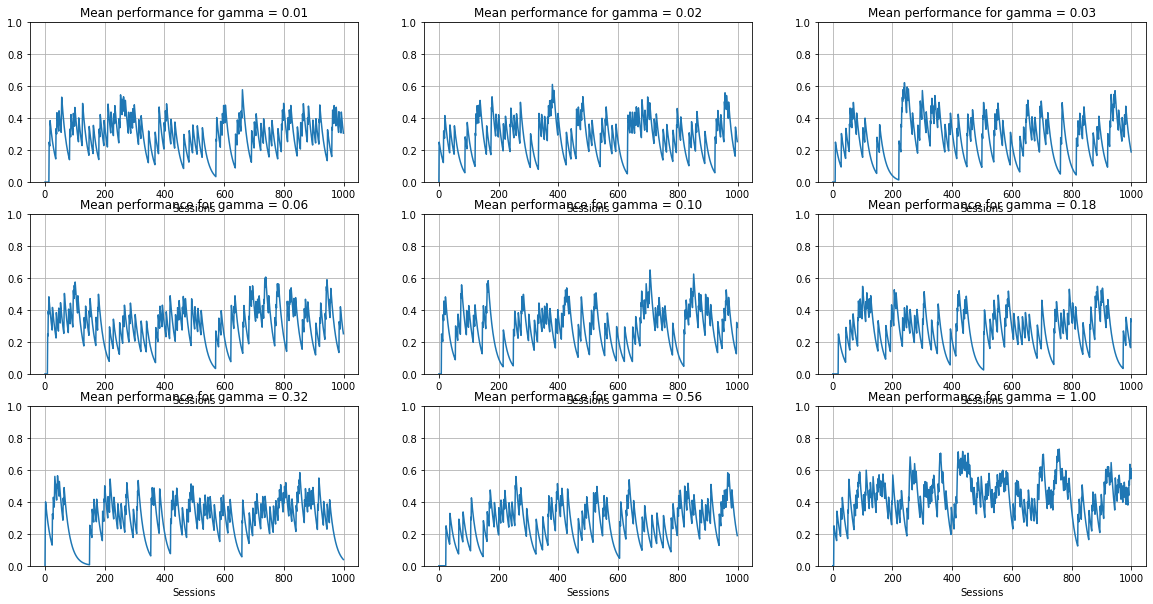

In [16]:
gammas = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMaze(eps=0.1)
    w.runSession(epochs=1000, maxlen=30, animate=False, mode="probabilistic", epsl=0.05, lambd=gammas[i*3 + j])
    w.errPlotter(ax=ax[i, j], title="Mean performance for gamma = {:.2f}".format(gammas[i*3 + j]))

## IV. TD($\lambda$) (deterministic)

In deterministic mode, TD($\lambda$) has the most convergence speed and optimum lambda is about 0.1, that means probably best error propagation rate is this rate, combining with optimum epsilon of 0.3.

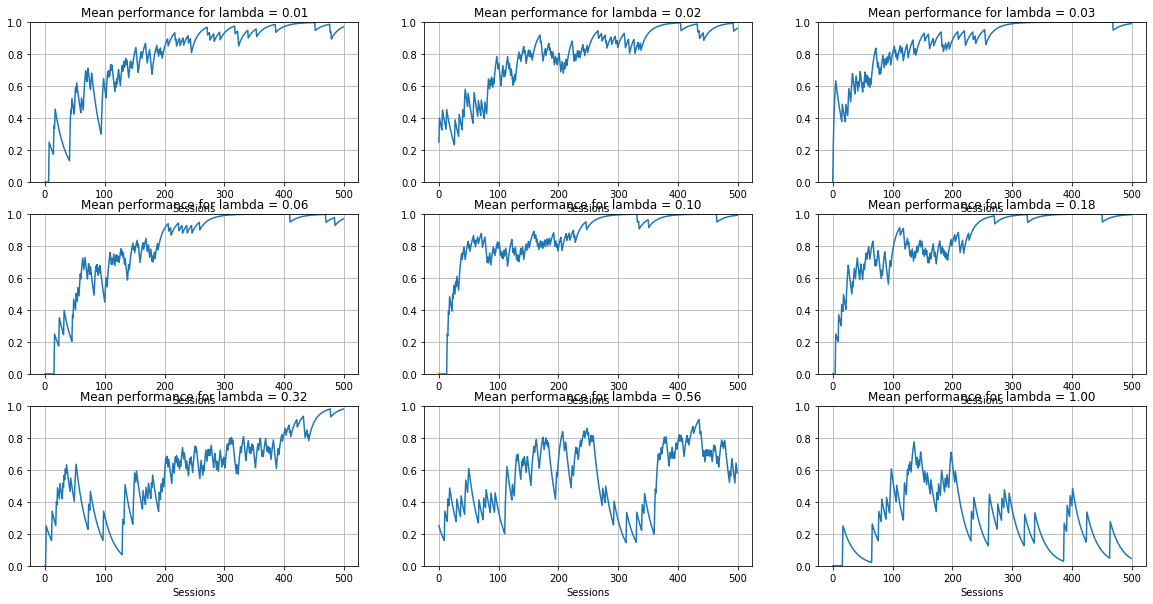

In [8]:
lambds = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMaze(eps=0.3)
    w.runSessionTD(epochs=500, maxlen=30, animate=False, mode="argmax", epsl=0.0, lambds=lambds[i*3 + j])
    w.errPlotter(ax=ax[i, j], title="Mean performance for lambda = {:.2f}".format(lambds[i*3 + j]))

## V. TD (Stochastic with exploration)

Stochastic TD with exploration has same problem with previous stochastic scenario, as this accuracy is based on all of map, this stochasticness causes bad-training for part of map that is near to punishment and well-training for part of map near targets, so expected accuracy will not be near 1 and for example, in hear it is about 0.6 in optimal form.

In [9]:
lambds = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMaze(eps=0.3)
    w.runSessionTD(epochs=1000, maxlen=30, animate=False, mode="probabilistic", epsl=0.05, lambds=lambds[i*3 + j])
    w.errPlotter(ax=ax[i, j], title="Mean performance for lambda = {:.2f}".format(lambds[i*3 + j]))

# Q4: Two-target procedure

In this part, we will change map with two targets with previous options, and then we change main parameters.

As we can see in all parts (expect stochastic mode) the convergence speed is increasing when $\epsilon$ is incresed from 0 to about 0.3, and then it gets oscillated for $\sim \epsilon > 0.4$, the convergence does not differ from previous part but there is another change, expected rewards near higher target are higher than lower target, as the reward propagation is higher in that and this causes the differece.

## I. MDM (deterministic)

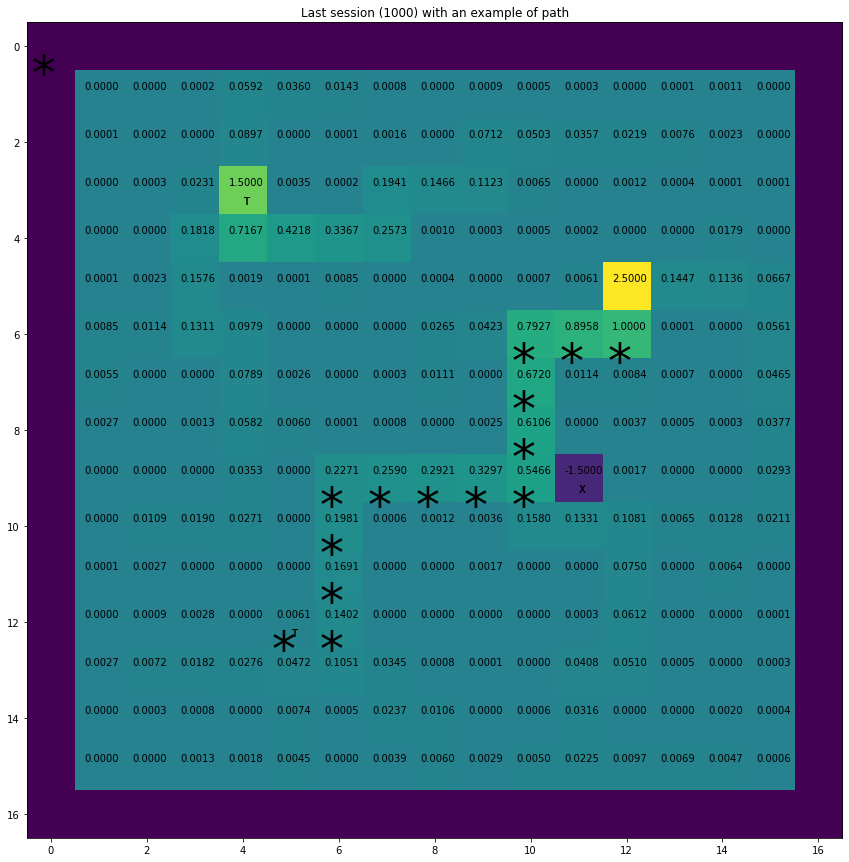

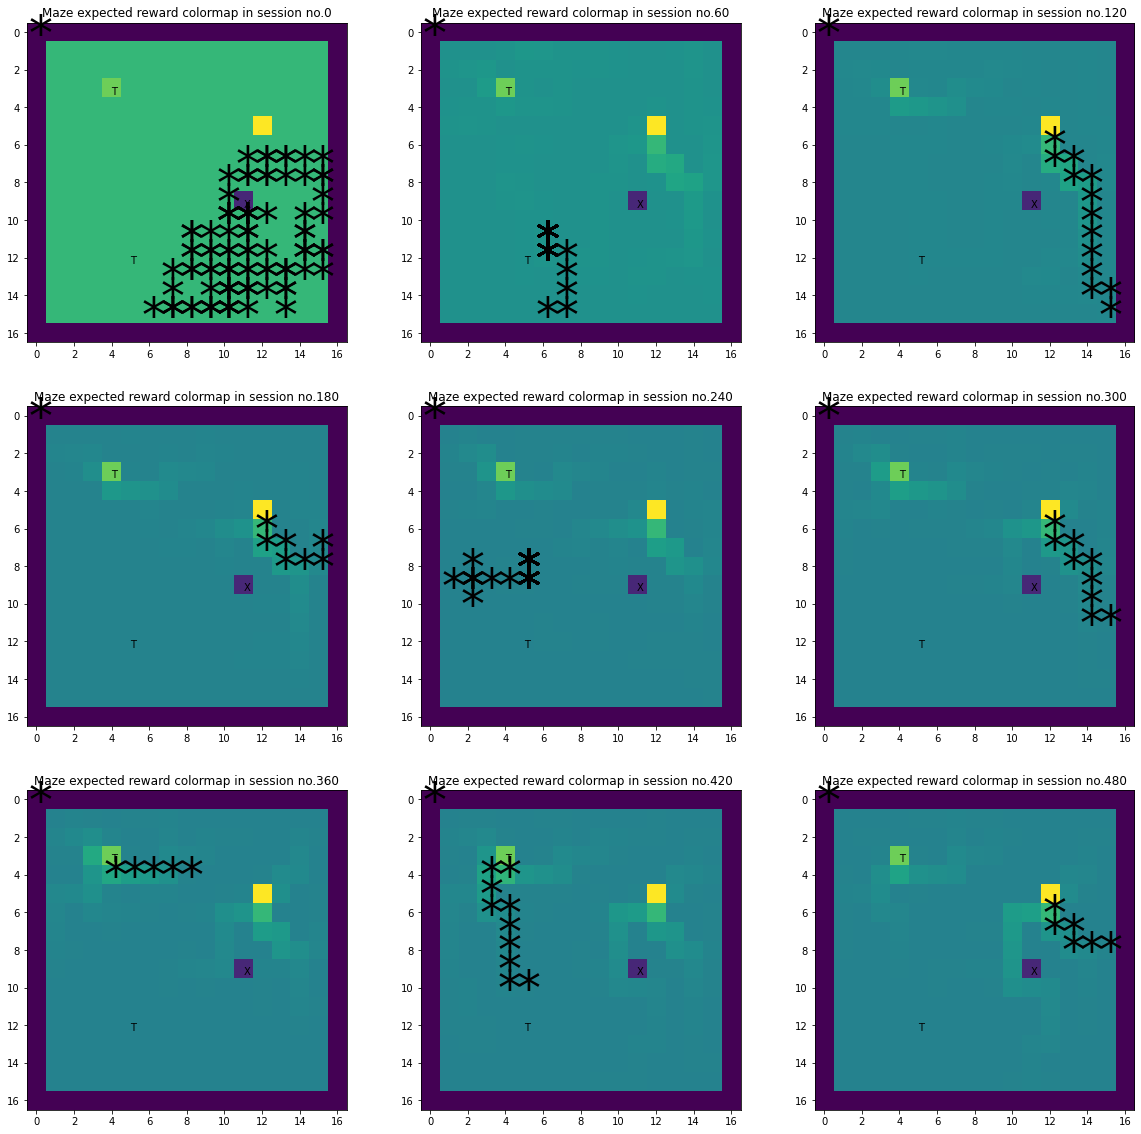

In [22]:
w1 = WaterMazeT(eps=0.1)
w1.runSession(epochs=1000, maxlen=100, animate=False, mode="argmax", epsl=0.0, lambd=1.0)
figs, plts = plt.subplots(figsize=(15, 15))

w1.animate(ax=plts)
w1.plotpath(ax=plts, title="Last session (1000) with an example of path", paths=w1.paths)
k = 60

fig, ax = plt.subplots(figsize=(20, 20), nrows=3, ncols=3)
for i in range(9):
  ax[int(i/3), i%3].imshow(w1.logs[i*k].maze)
  ax[int(i/3), i%3].set_title("Maze expected reward colormap in session no." + str(i*k))
  w1.plotpath(ax=ax[int(i/3), i%3], title="Maze expected reward colormap in session no." + str(i*k), paths=w1.logs[i*k].path)

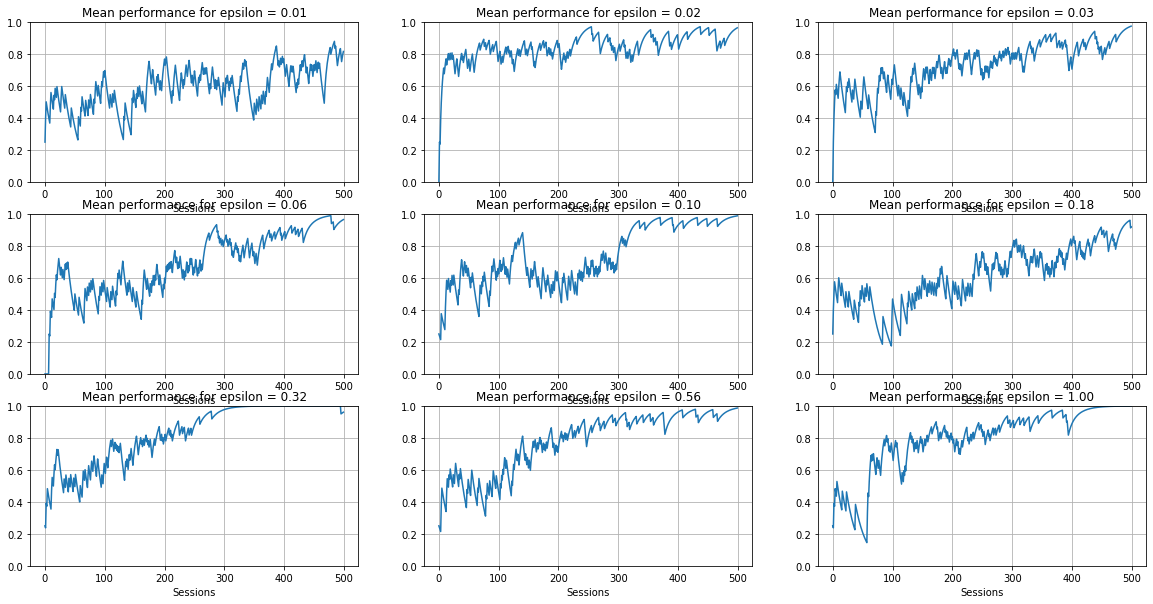

In [23]:
epsil = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMazeT(eps=epsil[i*3 + j])
    w.runSession(epochs=500, maxlen=50, animate=False, mode="argmax", epsl=0.0, lambd=1.0)
    w.errPlotter(ax=ax[i, j], title="Mean performance for epsilon = {:.2f}".format(epsil[i*3 + j]))

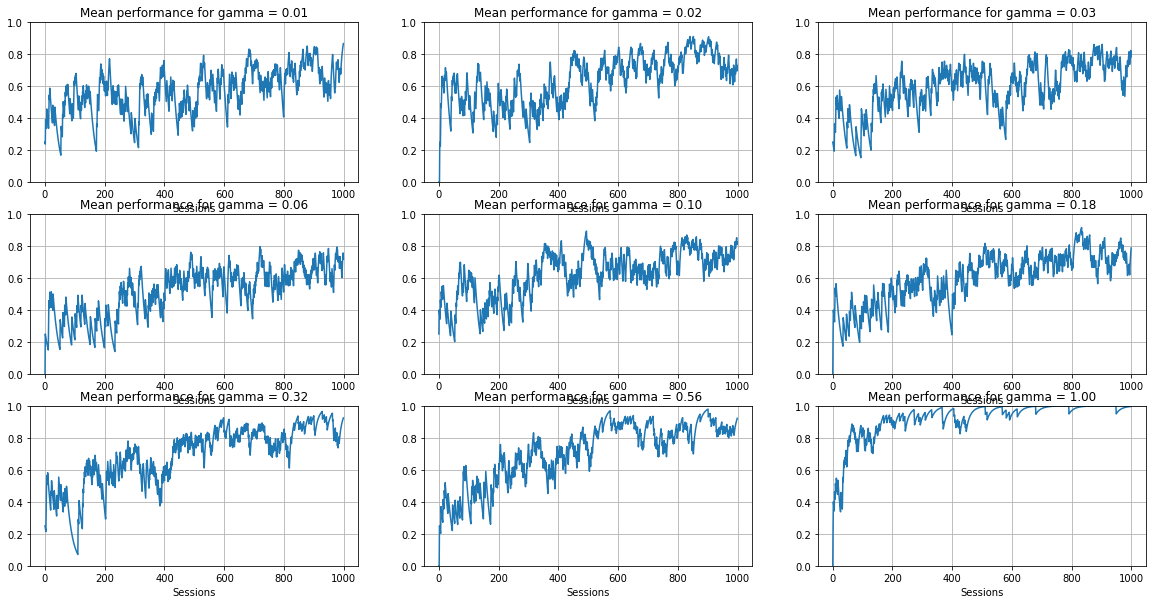

In [24]:
gammas = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMazeT(eps=0.1)
    w.runSession(epochs=1000, maxlen=30, animate=False, mode="argmax", epsl=0.0, lambd=gammas[i*3 + j])
    w.errPlotter(ax=ax[i, j], title="Mean performance for gamma = {:.2f}".format(gammas[i*3 + j]))

## II. MDM (stochastic)

Stochastic approach almost have no gaurantee for good decision, as training phase is stochastic some part of map that is very far from tragets will be bad-trained and the expected reward is bad-scaled near the punishment. 

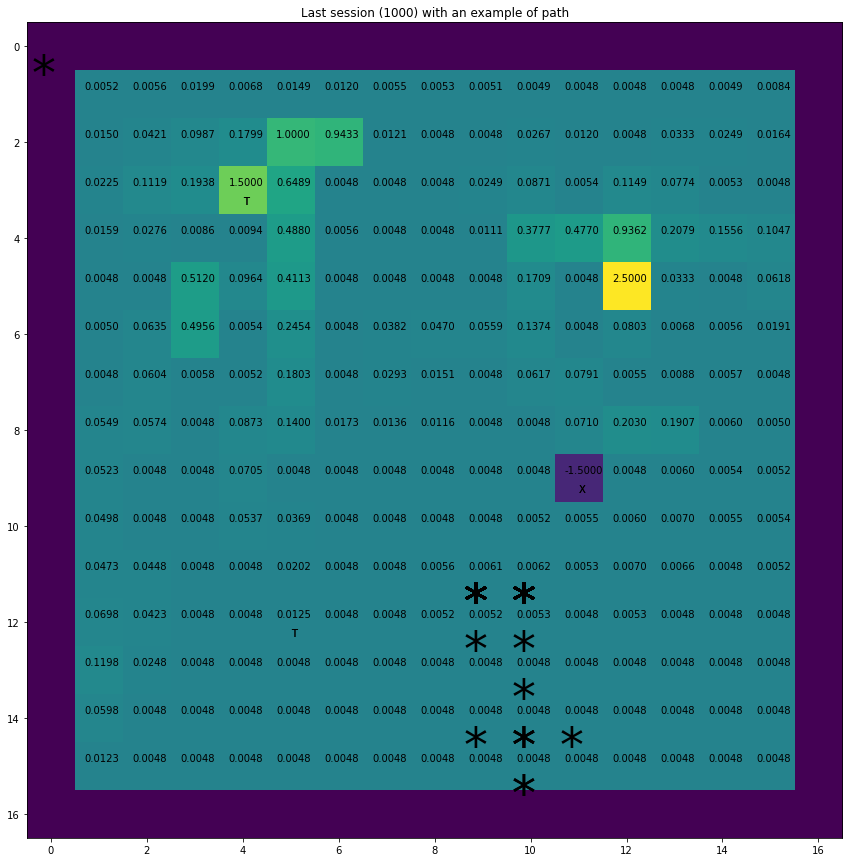

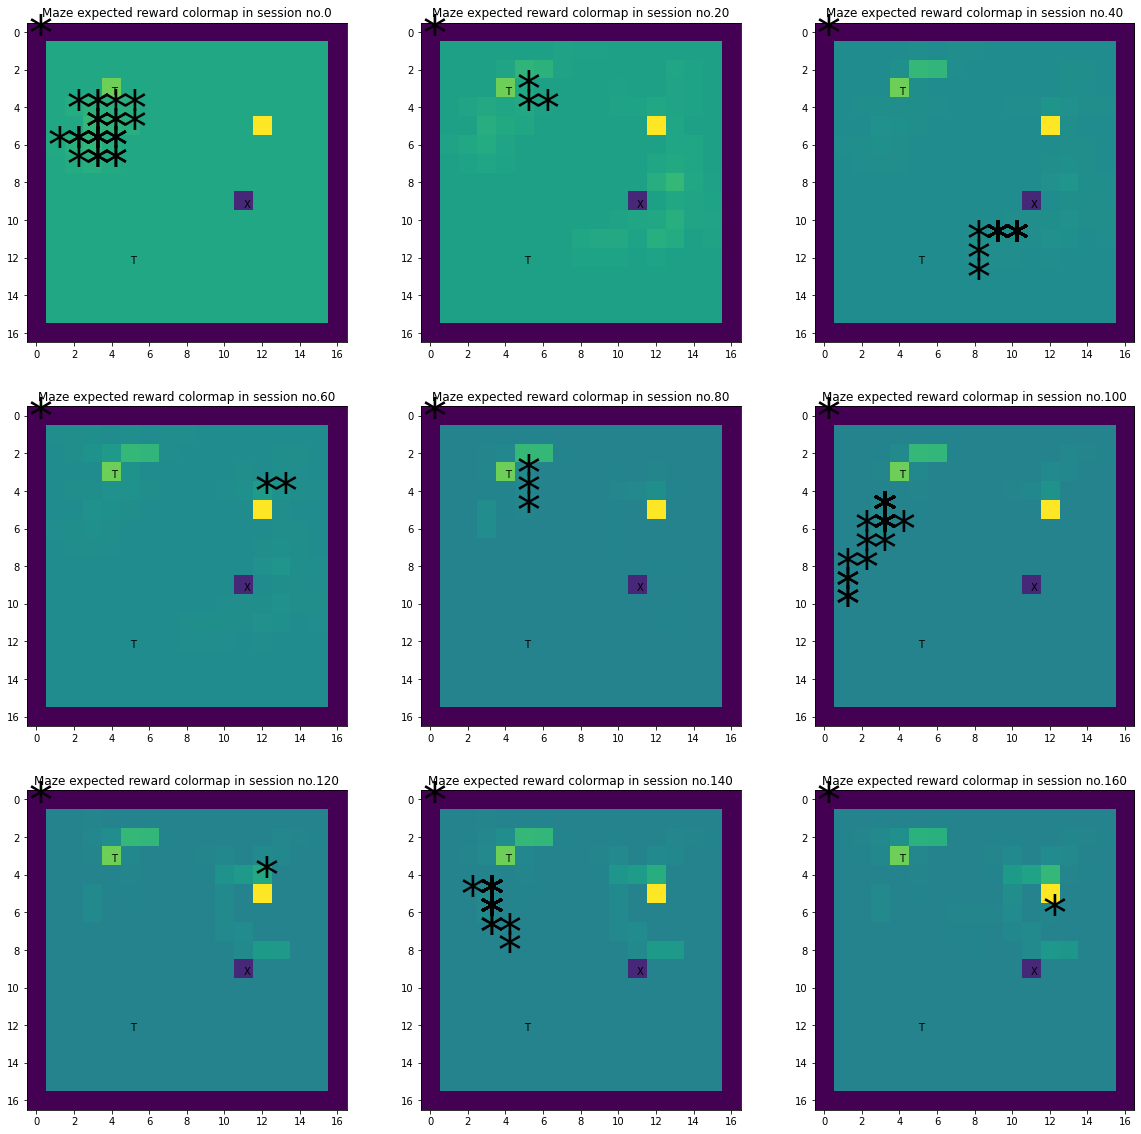

In [25]:
w2 = WaterMazeT(eps=0.1)
w2.runSession(epochs=200, maxlen=100, animate=False, mode="argmax", epsl=0.03, lambd=1.0)
figs, plts = plt.subplots(figsize=(15, 15))

w2.animate(ax=plts)
w2.plotpath(ax=plts, title="Last session (1000) with an example of path", paths=w2.paths)
k = 20

fig, ax = plt.subplots(figsize=(20, 20), nrows=3, ncols=3)
for i in range(9):
  ax[int(i/3), i%3].imshow(w2.logs[i*k].maze)
  ax[int(i/3), i%3].set_title("Maze expected reward colormap in session no." + str(i*k))
  w2.plotpath(ax=ax[int(i/3), i%3], title="Maze expected reward colormap in session no." + str(i*k), paths=w2.logs[i*k].path)

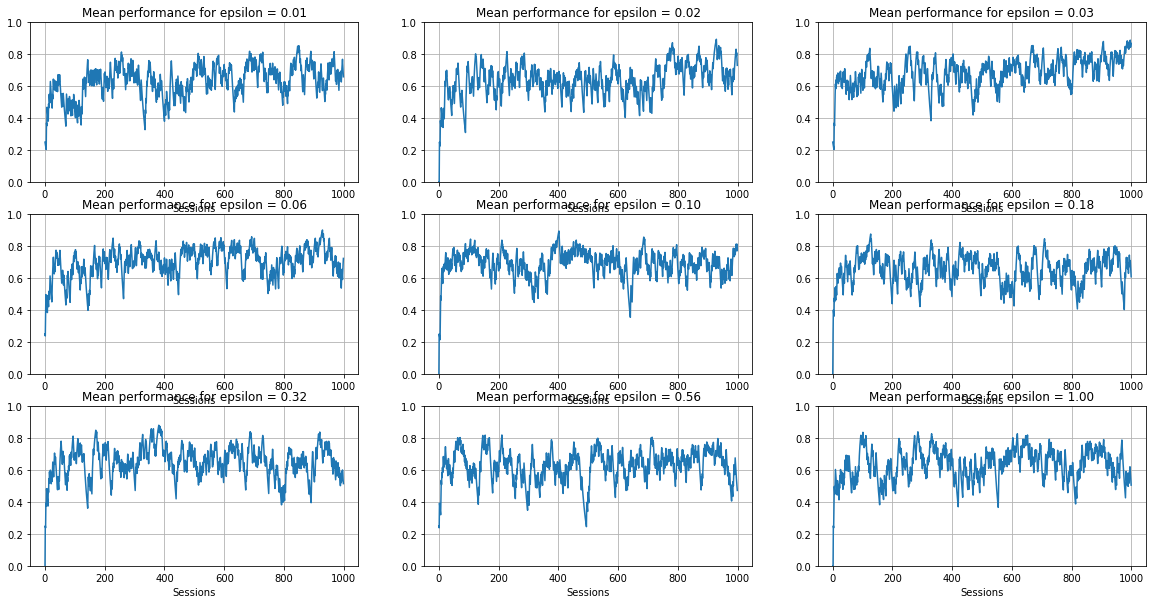

In [26]:
epsil = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMazeT(eps=epsil[i*3 + j])
    w.runSession(epochs=1000, maxlen=50, animate=False, mode="probabilistic", epsl=0.0, lambd=1.0)
    w.errPlotter(ax=ax[i, j], title="Mean performance for epsilon = {:.2f}".format(epsil[i*3 + j]))

In [27]:
gammas = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMazeT(eps=0.1)
    w.runSession(epochs=1000, maxlen=30, animate=False, mode="probabilistic", epsl=0.0, lambd=gammas[i*3 + j])
    w.errPlotter(ax=ax[i, j], title="Mean performance for gamma = {:.2f}".format(gammas[i*3 + j]))

## III. MDM (exploration)

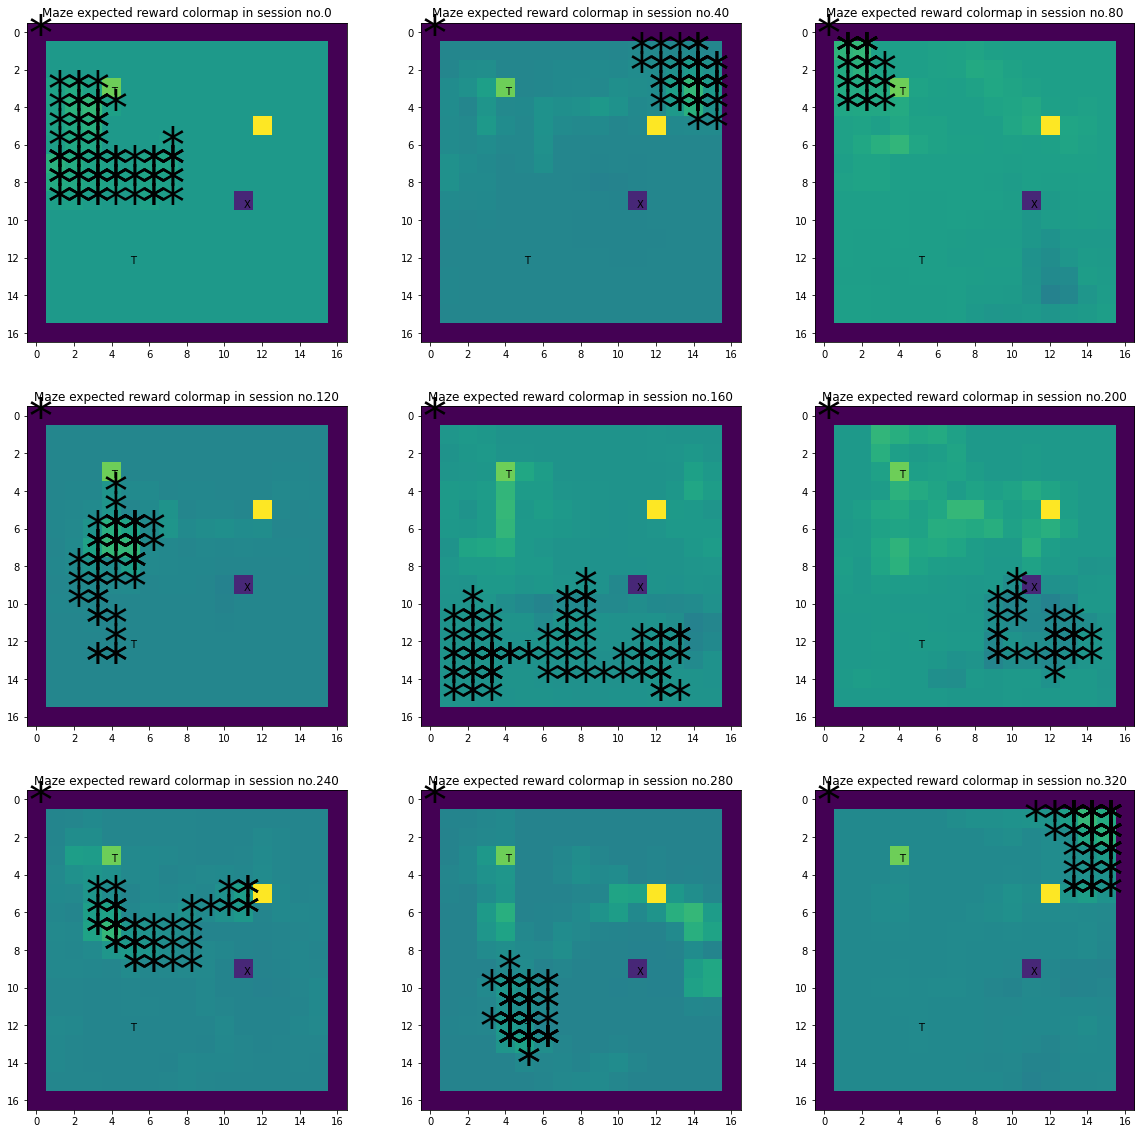

In [28]:
w4 = WaterMazeT(eps=0.2)
w4.runSession(epochs=400, maxlen=100, animate=False, mode="probabilistic", epsl=0.03, lambd=1.0)
figs, plts = plt.subplots(figsize=(15, 15))

w4.animate(ax=plts)
w4.plotpath(ax=plts, title="Last session (400) with an example of path", paths=w4.paths)
k = 40

fig, ax = plt.subplots(figsize=(20, 20), nrows=3, ncols=3)
for i in range(9):
  ax[int(i/3), i%3].imshow(w4.logs[i*k].maze)
  ax[int(i/3), i%3].set_title("Maze expected reward colormap in session no." + str(i*k))
  w4.plotpath(ax=ax[int(i/3), i%3], title="Maze expected reward colormap in session no." + str(i*k), paths=w4.logs[i*k].path)

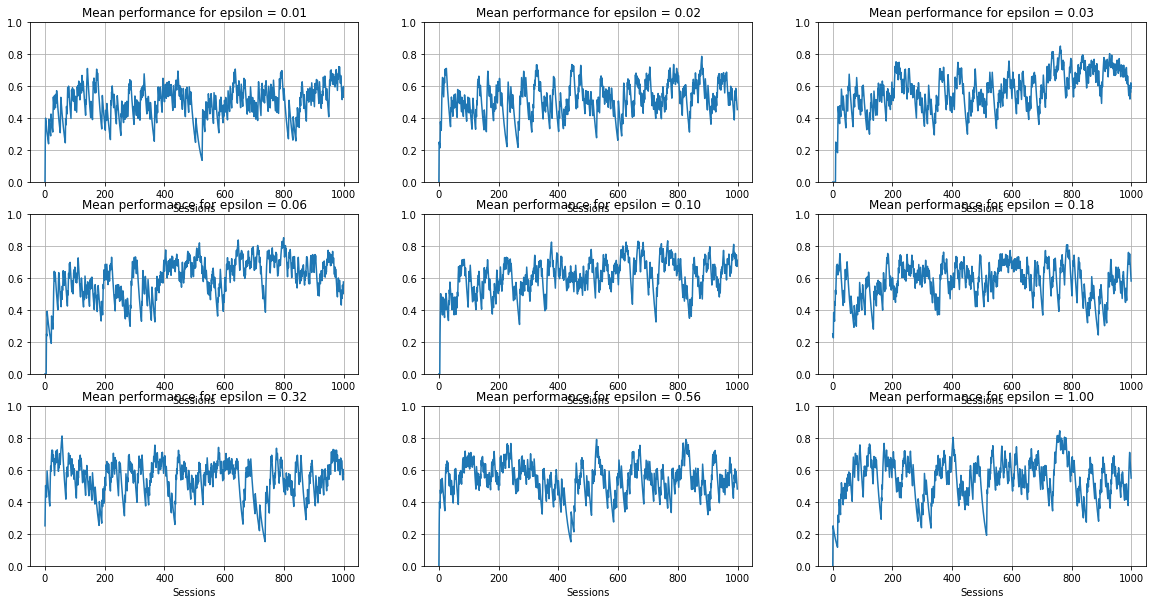

In [29]:
epsil = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMazeT(eps=epsil[i*3 + j])
    w.runSession(epochs=1000, maxlen=30, animate=False, mode="probabilistic", epsl=0.1, lambd=1.0)
    w.errPlotter(ax=ax[i, j], title="Mean performance for epsilon = {:.2f}".format(epsil[i*3 + j]))

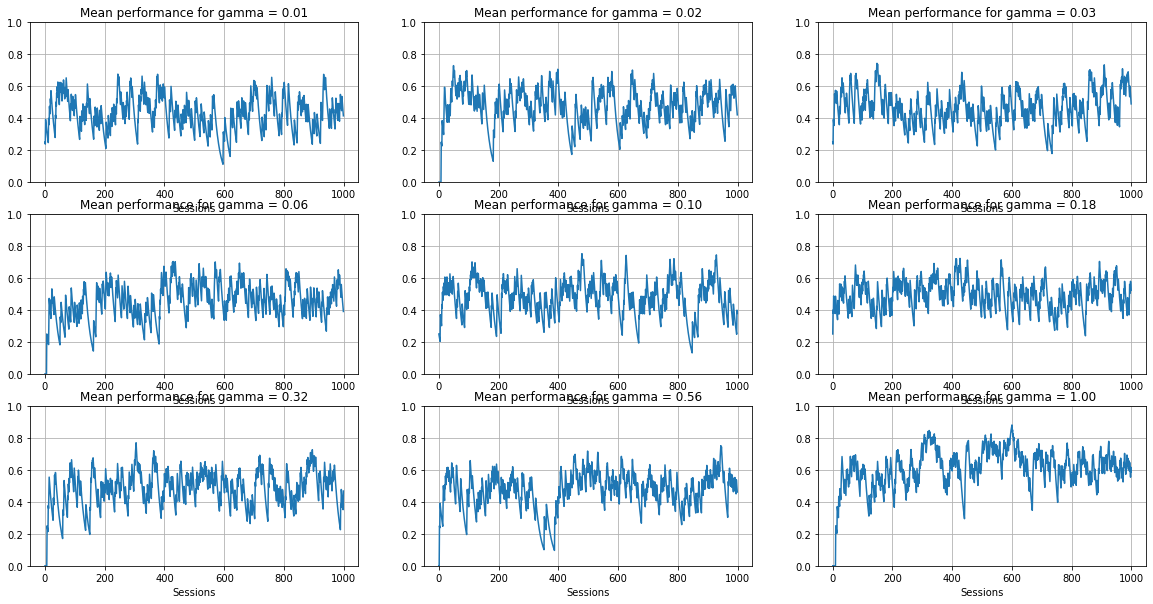

In [30]:
gammas = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMazeT(eps=0.1)
    w.runSession(epochs=1000, maxlen=30, animate=False, mode="probabilistic", epsl=0.05, lambd=gammas[i*3 + j])
    w.errPlotter(ax=ax[i, j], title="Mean performance for gamma = {:.2f}".format(gammas[i*3 + j]))

## IV. TD (deterministic)

In deterministic TD, everything is similar with one target mode but as we have no transient probability and path choosing is based on highest probability so after some seesions, the error rate will be very low as we can see here.

In [31]:
w5 = WaterMazeT(eps=0.2)
w5.runSessionTD(epochs=400, maxlen=100, animate=False, mode="argmax", epsl=0.0, lambds=1.0)
figs, plts = plt.subplots(figsize=(15, 15))

w5.animate(ax=plts)
w5.plotpath(ax=plts, title="Last session (400) with an example of path", paths=w5.paths)
k = 40

fig, ax = plt.subplots(figsize=(20, 20), nrows=3, ncols=3)
for i in range(9):
  ax[int(i/3), i%3].imshow(w5.logs[i*k].maze)
  ax[int(i/3), i%3].set_title("Maze expected reward colormap in session no." + str(i*k))
  w5.plotpath(ax=ax[int(i/3), i%3], title="Maze expected reward colormap in session no." + str(i*k), paths=w5.logs[i*k].path)

In [32]:
epsil = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMazeT(eps=epsil[i*3 + j])
    w.runSessionTD(epochs=1000, maxlen=100, animate=False, mode="argmax", epsl=0.0, lambds=0.8)
    w.errPlotter(ax=ax[i, j], title="Mean performance for epsilon = {:.2f}".format(epsil[i*3 + j]))

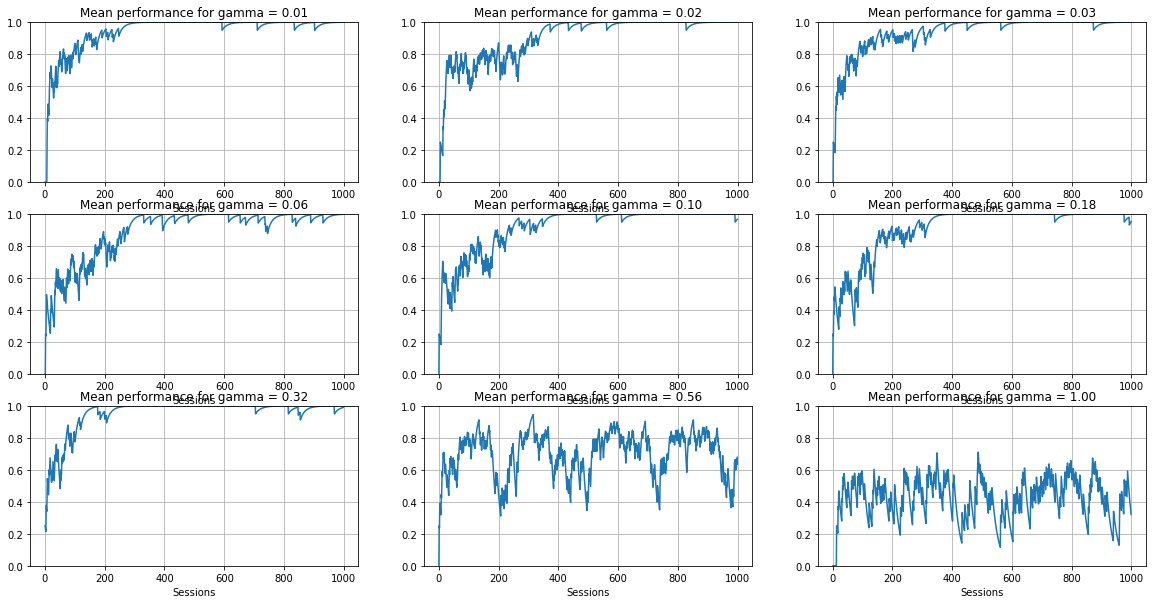

In [33]:
lambds = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMazeT(eps=0.5)
    w.runSessionTD(epochs=1000, maxlen=30, animate=False, mode="argmax", epsl=0.0, lambds=lambds[i*3 + j])
    w.errPlotter(ax=ax[i, j], title="Mean performance for gamma = {:.2f}".format(lambds[i*3 + j]))

## V. TD (exploration)

Again, as we expected before, the contour heatmap is higher near targets and lower near the punishment, although we have two targets, the other significant observation is that the values near the higher target are higher.

In [34]:
w5 = WaterMazeT(eps=0.2)
w5.runSessionTD(epochs=400, maxlen=100, animate=False, mode="probabilistic", epsl=0.03, lambds=1.0)
figs, plts = plt.subplots(figsize=(15, 15))

w5.animate(ax=plts)
w5.plotpath(ax=plts, title="Last session (400) with an example of path", paths=w5.paths)
k = 40

fig, ax = plt.subplots(figsize=(20, 20), nrows=3, ncols=3)
for i in range(9):
  ax[int(i/3), i%3].imshow(w5.logs[i*k].maze)
  ax[int(i/3), i%3].set_title("Maze expected reward colormap in session no." + str(i*k))
  w5.plotpath(ax=ax[int(i/3), i%3], title="Maze expected reward colormap in session no." + str(i*k), paths=w5.logs[i*k].path)

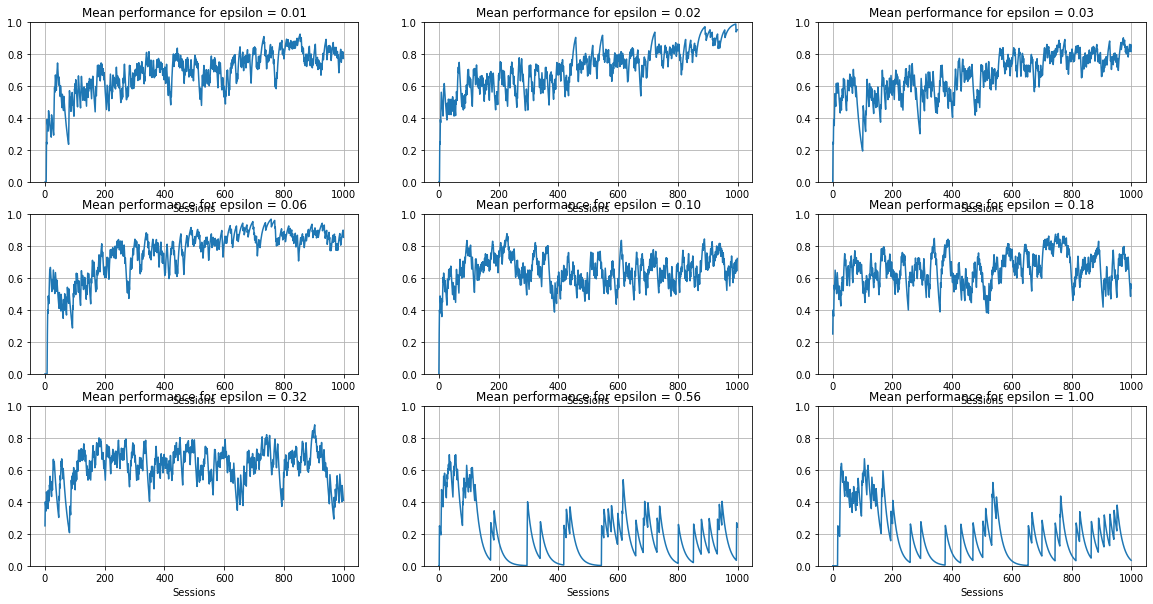

In [39]:
epsil = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMazeT(eps=epsil[i*3 + j])
    w.runSessionTD(epochs=1000, maxlen=30, animate=False, mode="argmax", epsl=0.1, lambds=0.8)
    w.errPlotter(ax=ax[i, j], title="Mean performance for epsilon = {:.2f}".format(epsil[i*3 + j]))

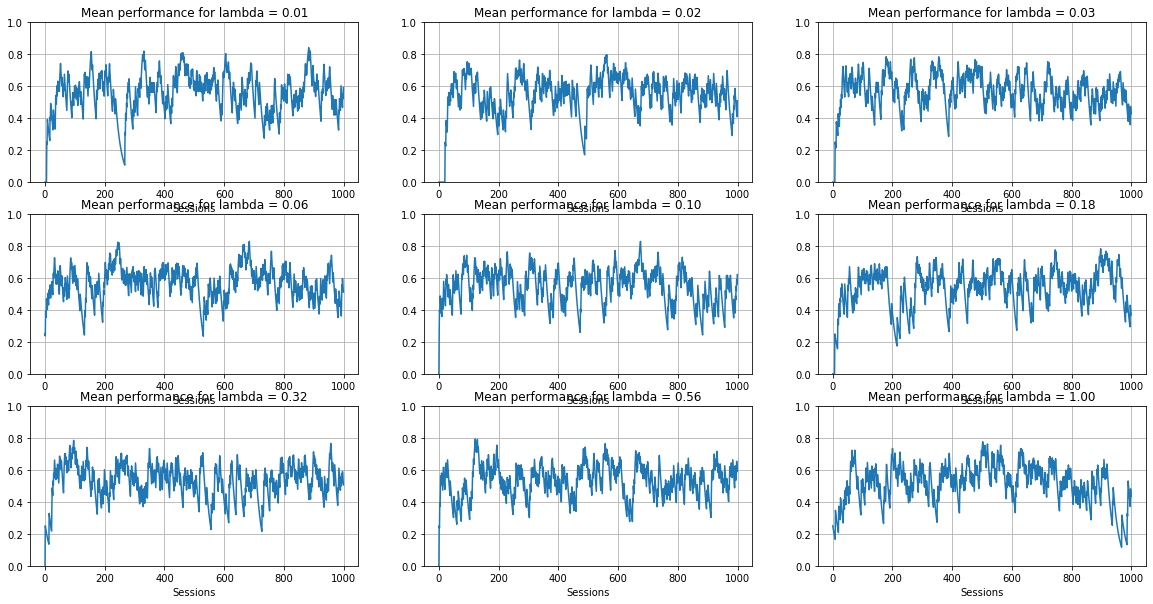

In [41]:
lambds = np.logspace(-2, 0, 9)
fig, ax = plt.subplots(figsize=(20, 10), ncols=3, nrows=3)
for i in range(3):
  for j in range(3):
    w = WaterMazeT(eps=0.5)
    w.runSessionTD(epochs=1000, maxlen=30, animate=False, mode="probabilistic", epsl=0.05, lambds=lambds[i*3 + j])
    w.errPlotter(ax=ax[i, j], title="Mean performance for lambda = {:.2f}".format(lambds[i*3 + j]))

### Comparison:

In TD-lambda approach, similar to other approaches when $\epsilon$ is increased from value near 0 to 1, at first learning speed (convergence speed) is increased and then, it gets unstable and oscillates; this may be due to large state steps and larger changes, and in lower learning rates the changes are lower obviously that cause lower speed in convergence.